# MCMC experiment: round 2

Mixture of Gaussians

In [1]:
using Gen
using PyPlot

## Define a model

In [2]:
@gen function gauss_mix(n_clusters::Int64, n_samples::Int64)
    
    cluster_means = [@trace(normal(0.0, 10.0), :means => i) for i=1:n_clusters]
    cluster_spreads = [@trace(gamma(1.0, 1.0), :spreads => i) for i=1:n_clusters]
    cluster_probs = fill(1.0/n_clusters, n_clusters)
    
    z = zeros(n_samples, 1)
    
    for j=1:n_samples
    
        c = @trace(categorical(cluster_probs), :cluster => j)
        z[j] = @trace(normal(cluster_means[c], cluster_spreads[c]), :z => j)
    end
    
    return z

end;

## Sanity check: simulate & visualize

In [3]:
n_samples = 500
n_clusters = 3
    
tr = simulate(gauss_mix, (n_clusters, n_samples));

In [7]:
function plot_trace(tr)
    
    zs = [tr[:z => j] for j=1:n_samples];
    means = [tr[:means => i] for i=1:n_clusters];
    assignments = [tr[:cluster => j] for j=1:n_samples]
    
    plot_choices(zs, means, assignments)

end

function plot_choices(zs, means, assignments)
    
    hist_colors = ["gray", "blue", "red", "orange", "yellow"]
    
    z_sets = []
    
    for (i, mean) in enumerate(means)
        plot([mean; mean], [0; n_samples], color="k")
        cluster_z = zs[assignments .== i]
        hist(cluster_z, 20, color=hist_colors[i])
    end
    
end;

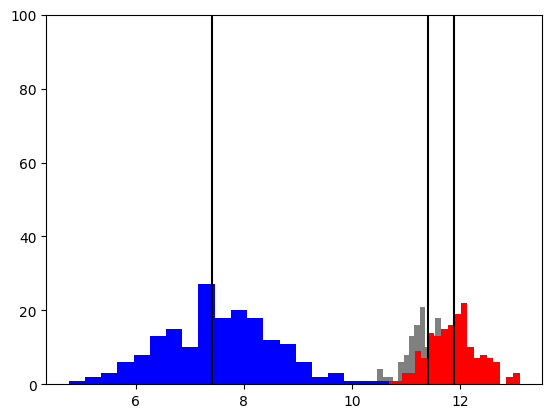

In [9]:
plot_trace(tr)
ylim(0, 100)
show()

## Inference: block resimulation

In [10]:
function block_resimulation_update(tr, n_clusters, n_data)

    # block 1: cluster locations and variances
    for i=1:n_clusters
        (tr, _) = Gen.mh(tr, select(:means => i))
        (tr, _) = Gen.mh(tr, select(:spreads => i))
    end
    
    # block 2: cluster assignments
    for j=1:n_data
        (tr, _) = Gen.mh(tr, select(:cluster => j))
    end
    
    return tr
end

block_resimulation_update (generic function with 1 method)

In [11]:
function block_resim_sample(n_clusters, data)
   
    # set up the constraints
    observations = Gen.choicemap()
    for (i, z) in enumerate(data)
        observations[:z => i] = z
    end
    
    # Initialize the state
    (tr, _) = Gen.generate(gauss_mix, (n_clusters, length(data)), observations)
    
    # This loop, in essence, performs thinning.
    for t=1:1
        tr = block_resimulation_update(tr, n_clusters, length(data))
    end
    
    return tr
end

block_resim_sample (generic function with 1 method)

In [12]:
function block_resim_inference(n_clusters, data, n_samples)
    
    centers = zeros((n_samples, n_clusters))
    assignments = zeros((length(data), n_clusters))
    
    for i=1:n_samples
        println("Sample ", i)
        sampled_tr = block_resim_sample(n_clusters, data)
        
        for k=1:n_clusters
            centers[i,k] = sampled_tr[:means => k]
        end
        for k=1:length(data)
            assignments[k,sampled_tr[:cluster => k]] += 1
        end
        
    end
    
    return centers, assignments 
end;

In [15]:
zs = [tr[:z => i] for i=1:n_samples];
centers, assignments = block_resim_inference(3, zs, 20)

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20


([-1.9743953468051192 11.18093822796274 10.385110657566063; 5.88530471161401 -10.879809371032113 7.0716248775362995; … ; -11.348563751510419 -8.49666917440127 -6.229508628003665; 10.061925347781795 10.919596629785318 -1.4731728035156613], [5.0 9.0 6.0; 5.0 5.0 10.0; … ; 4.0 8.0 8.0; 7.0 6.0 7.0])

In [16]:
centers

20×3 Array{Float64,2}:
  -1.9744       11.1809    10.3851  
   5.8853      -10.8798     7.07162 
  10.2016       15.9564     7.11528 
  -0.974523      9.6182     8.33206 
   5.09547      11.4203     3.76698 
  -0.00429222    2.6104     1.94812 
   7.20625      -0.535058   3.59994 
  -5.64509      11.0726    -7.53711 
  -1.84194       4.43955   -7.51937 
   3.43083      14.6049    10.2065  
   9.08906      -0.412451   8.6951  
  -4.1575       -1.11492   14.4886  
  -6.81282      -3.08237   14.2036  
   0.531259     13.3425    22.8631  
   4.46792      -7.4889    12.4672  
  10.8463       11.5037     7.96728 
  12.7247        6.74102    6.91529 
  12.7342       10.2467     0.679581
 -11.3486       -8.49667   -6.22951 
  10.0619       10.9196    -1.47317 

## Inference: k-means guided resampling

Our straightforward approach had some issues -- especially with identifiability.

During resampling, there was little reason for 

In [ ]:
using Statistics

function mean_update(data, cluster_assignments, k)
    return [mean(data[cluster_assignments .== i]) for i=1:k]
end

function cluster_update(data, means)
    
    dists = map(abs, data .- transpose(means))
    min_inds = argmin(dists, dims=2)
    
    return [min_inds[i][2] for i=1:length(min_inds)]
end


function kmeans(data::Array{Float64,1}, k::Int64, spread=1.0, max_iter::Int64=1000)
    
    # random initialization
    cluster_assignments = zeros(size(data)[1])
    means = rand(data, k)
    
    i = 1
    while i <= max_iter
        
        cluster_assignments = cluster_update(data, means)
        new_means = mean_update(data, cluster_assignments, k)
        
        if new_means == means
            break
        end
        
        means = new_means
        i += 1
        
    end
    
    # Sort the means in order to ameliorate
    # identifiability issues.
    srt_inds = sortperm(means)
    inv_map = zeros(size(srt_inds))
    for (i, ind) in enumerate(srt_inds)
        inv_map[ind] = i
    end
    ca = map(x->inv_map[x], cluster_assignments)
    
    return means[srt_inds], ca
end

In [ ]:

means, assignments = kmeans(zs, 5, 10.0, 1000)

plot_choices(zs, means, assignments)
ylim(0.0, 30.0)
show()

In [ ]:
generate()